In [1]:
import sys, wave
import numpy as np
from numpy import array, int16
from scipy.signal import lfilter, butter
from scipy.io.wavfile import read,write
from scipy import signal
from IPython.lib.display import Audio
from scipy.fftpack import fft , ifft, fftshift, ifftshift 
import matplotlib.pyplot as plt
from scipy.io import loadmat

pi = np.pi
gsignal = 0
Fs = 0
xn = 0

In [8]:
def Read_Audio(filename):
    global Fs, xn
    Fs, xn = read(filename)
    xn = convert_to_mono_audio(xn)
    Plot_Spectrum(xn, 10000)
    Plot_Waveform(xn,Fs)
    global gsignal
    gsignal = xn
    
def Plot_Spectrum(signal, points):        #Herhangi bir sinyalin arzu edilen noktada fourieri alınıp çizilmesi
    N = points
    w = np.arange(-pi,pi, 2*pi/N)
    xw = fftshift(fft(signal, N)/N)
    plt.figure()
    plt.stem(w/np.pi, abs(xw))
    plt.xlabel('w*$\pi$')
    plt.title('Genlik Grafiği')

def Plot_Waveform(signal, Fs):
    N = len(signal)
    n = np.arange(0, N)
    plt.figure()
    plt.plot(n/Fs,signal) # zaman cinsinden belirtmek için n/Fs yapılmıştır.
    plt.xlabel("t")
    plt.title('Signal')

def convert_to_mono_audio(input_audio):
    output_audio = []
    temp_audio = input_audio.astype(float)
    for i in temp_audio:
        output_audio.append((i[0] / 2) + (i[1] / 2))   #2 sütundaki değerlerin ortalaması alındı ve bunlar tek kanala sokuldu.
    return np.array(output_audio, dtype = 'int16')
        
def set_reverse(input_audio):
    global Fs, xn
    input_audio = input_audio[::-1]  #Satır ve sütunların yeri değiştirilerek ses tersten oynatılacak
    global gsignal
    gsignal = input_audio
    display(Audio(input_audio, rate=Fs))
    return input_audio

def set_echo(delay, audio_data, gain):
    output_audio = np.zeros(len(audio_data))
    output_delay = delay * Fs
    
    for count, i, in enumerate(audio_data):
        output_audio[count] = i + gain * audio_data[count - int(output_delay)]
   
    audio_data = output_audio
    global gsignal
    gsignal = audio_data
    return audio_data
    
def set_speed(speed_factor, xn):
    sound_index = np.round(np.arange(0, len(xn), speed_factor))
    xn = xn[sound_index[sound_index < len(xn)].astype(int)]
    global gsignal
    gsignal = xn
    display(Audio(xn, rate=Fs))

def distortion(x, gain):
    q=x*gain/np.max(np.abs(x));
    z=np.sign(-q)*(1-np.exp(np.sign(-q)*q))
    y=z*np.max(np.abs(x))/np.max(np.abs(z))
    return y

def bass_effect(xn, gain):
    filter_data = loadmat('filters/bass_lpf.mat') #fc =250Hz
   
    Coeffs = filter_data['ba'].astype(np.float) 
    b = Coeffs[0,:] 
    yn = lfilter(b, 1,xn*gain)   
    
    final_audio = (yn + xn)/2
    return final_audio

def treble_effect(xn, gain):
    filter_data = loadmat('filters/treble_hp.mat') #fc =4000Hz
    
    Coeffs = filter_data['ba'].astype(np.float) 
    b = Coeffs[0,:] 
    yn = lfilter(b, 1,xn*gain)
    
    final_audio = (yn + xn)/2
    return final_audio

def equalizer(xn, gain, mode): 
        
        # N = 1000
            
        # 20Hz-60Hz-->Sub-bass   
        if mode == 1:   
            efilter_data = loadmat('filters/equalizer_20Hz-60Hz.mat') 
            
        # 60Hz-200Hz-->Bass
        elif mode == 2: 
            efilter_data  = loadmat('filters/equalizer_60Hz-250Hz.mat') 
            
        # 200Hz-600Hz-->Lower mids
        elif mode == 3: 
            efilter_data  = loadmat('filters/equalizer_200Hz-600Hz.mat') 
            
        # 600Hz-3kHz-->Mids
        elif mode == 4: 
            efilter_data  = loadmat('filters/equalizer_600Hz-3kHz.mat') 
            
        # 3kHz-8kHz-->Upper-Mids
        elif mode == 5: 
            efilter_data  = loadmat('filters/equalizer_3kHz-8kHz.mat') 
            
        # 8kHz-20kHz-->Highs
        elif mode == 6: 
            efilter_data  = loadmat('filters/equalizer_8kHz-20kHz.mat') 
         
        Coeffs = efilter_data ['ba'].astype(np.float) 
        b = Coeffs[0,:] 
        yn = lfilter(b, 1,xn*gain)   
        equ_audio = yn
        final_audio = (equ_audio + xn)/2
        
        return final_audio, equ_audio    
 

 def find_name(file):
    for index in range(len(file)):
        if file[::-1][index] == '.':
            index += 1
            break
    return file[:-index]

def Save_output(filename):     #Dosya kaydeden fonksiyon
    global Fs
    write(filename, Fs, array(xn, dtype = int16))
    
def reverb(loadname ,xn):
    # Import Music
    audio = read(loadname)
    xn = np.array(audio[1], dtype='float')
    Fs = audio[0]

    # Import Impulse
    impulse = read("French_18th_Century_Salon.wav")
    impulse_arr = np.array(impulse[1], dtype='float')
    impulse_arr = np.multiply(impulse_arr, 1.0/np.max(impulse_arr))

    # Convert Reverb
    filtered = signal.convolve(xn, impulse_arr, mode='same', method='fft')
    filtered = np.multiply(filtered, 1.0/np.max(np.abs(filtered)))

    # Write to the file
    if find_name('Reverb_Effect_1.wav') != 'Reverb_Effect_1.wav':
        write("Reverb_Effect_1.wav", rate=int(Fs), data=filtered.astype(np.float32))

    ############ Demonstration #############

    # Normal Sound with Reverb Effect
    Fs_r, xr = read("Reverb_Effect_1.wav")
    xr_n = xr[:,1]

    display(Audio(xr_n, rate=Fs_r))


AUDIO FILES:
1. Ichika Nito - When a band only give you 5 seconds to audition 
2. ...
3. ...
4. ...
5. ...

Choose an audio file: 1


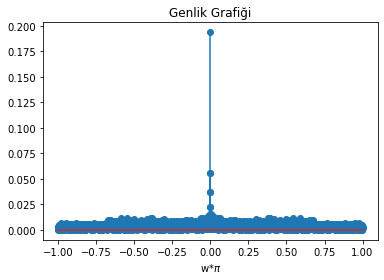

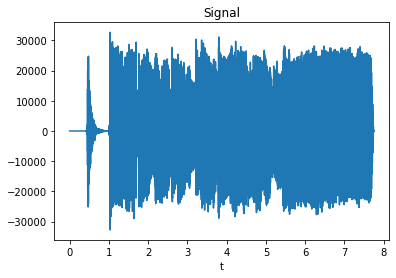

In [7]:
######## MENU SYSTEM #########

print("""
AUDIO FILES:
1. Ichika Nito - When a band only give you 5 seconds to audition 
2. ...
3. ...
4. ...
5. ...
""")
ans=input("Choose an audio file: ")
if ans=="1":
    Read_Audio("videoplayback.wav")
elif ans=="2":
    Read_Audio("videoplayback.wav")
elif ans=="3":
    Read_Audio("videoplayback.wav")
elif ans=="4":
    Read_Audio("videoplayback.wav")
elif ans=="5":
    Read_Audio("videoplayback.wav") 

In [4]:
ans = True
while ans:
    print("""
    ***************************
    *   1. Reverse Effect     *
    *   2. Echo Effect        *
    *   3. Speed Effect       *
    *   4. Distortion Effect  * 
    *   5. Bass Effect        *
    *   6. Treble Effect      *
    *   7. Reverb Effect      *
    *   8. Equalizer Settings * 
    *   9. Exit               * 
    ***************************
    """)
    ans=input("Choose a number: ")
    #SUCCESS
    if ans=="1":
        reverse_audio = set_reverse(xn)
        Plot_Waveform(xn, Fs)
    #SUCCESS
    elif ans=="2":
        delay = float(input("Choose delay: "))
        gain = float(input("Choose gain: "))
        echo_audio = set_echo(delay, xn, gain) 
        Plot_Waveform(xn, Fs)
        display(Audio(echo_audio, rate=Fs))    
    #SUCCESS
    elif ans=="3":
        speed_factor = float(input("Choose speed factor: "))
        set_speed(speed_factor, xn)
    #SUCCESS
    elif ans=="4":
        gain = float(input("Choose gain: "))
        dist_audio = distortion(xn, gain)
        display(Audio(dist_audio, rate=Fs))
    #SUCCESS
    elif ans=="5":
        gain = float(input("Choose gain: "))
        bass_audio = bass_effect(xn, gain)
        display(Audio(bass_audio, rate=Fs))
    #SUCCESS
    elif ans=="6":
        gain = float(input("Choose gain: "))
        treble_audio = treble_effect(xn, gain)
        display(Audio(treble_audio, rate=Fs))
    #SUCCESS
    elif ans=="7":       
        reverb('videoplayback.wav', xn)
    #SUCCESS
    elif ans=="8":
        print("""
        MODES:
        1. Sub-bass
        2. Bass
        3. Lower Mids
        4. Mids
        5. Upper Mids
        6. Highs
        """)        
        mode = float(input("Choose mode: "))
        gain = float(input("Choose gain: "))   
        print("\n")
        final_audio, equ_audio = equalizer(xn, gain, mode)
        print("Final Audio")
        display(Audio(final_audio, rate=Fs))
        print("Equalized Audio")
        display(Audio(equ_audio, rate=Fs))
    elif ans=="9":
        print("\n Exit") 
        ans = None
    else:
        print("\n Not Valid Choice Try again")


    ***************************
    *   1. Reverse Effect     *
    *   2. Echo Effect        *
    *   3. Speed Effect       *
    *   4. Distortion Effect  * 
    *   5. Bass Effect        *
    *   6. Treble Effect      *
    *   7. Reverb Effect      *
    *   8. Equalizer Settings * 
    *   9. Exit               * 
    ***************************
    
Choose a number: 8

        MODES:
        1. Sub-bass
        2. Bass
        3. Lower Mids
        4. Mids
        5. Upper Mids
        6. Highs
        
Choose mode: 6
Choose gain: 1


Final Audio


Equalized Audio



    ***************************
    *   1. Reverse Effect     *
    *   2. Echo Effect        *
    *   3. Speed Effect       *
    *   4. Distortion Effect  * 
    *   5. Bass Effect        *
    *   6. Treble Effect      *
    *   7. Reverb Effect      *
    *   8. Equalizer Settings * 
    *   9. Exit               * 
    ***************************
    
Choose a number: 8

        MODES:
        1. Sub-bass
        2. Bass
        3. Lower Mids
        4. Mids
        5. Upper Mids
        6. Highs
        
Choose mode: 4
Choose gain: 45


Final Audio


Equalized Audio



    ***************************
    *   1. Reverse Effect     *
    *   2. Echo Effect        *
    *   3. Speed Effect       *
    *   4. Distortion Effect  * 
    *   5. Bass Effect        *
    *   6. Treble Effect      *
    *   7. Reverb Effect      *
    *   8. Equalizer Settings * 
    *   9. Exit               * 
    ***************************
    
Choose a number: 9

 Exit
